# Introduction

This notebook showcases the pythonic way of building and comparing the performances of three different types of portfolio on the top ten SBF120 stocks with the highest market caps at the end of 2018. The returns are calculated with the stocks data from the year 20129. The three portfolios are as follows:
1) Equally weighted Portfolio

2) Markowitze Minimum Variance Portfolio

3) Equally-Weighted Risk Contribution Portfolio

The comparision of the performance is done based on two specific metrics: Sharpe Ratio and Maximum drawdown

# Sharpe Ratio

The Sharpe Ratio is the ratio between the return of a portfolio with the risk associated with that portfolio. 

$$
  Sharpe Ratio = \frac{R_p-R_f}{\sigma_p}
$$

Where
${R_p}$ = Portfolio Risk, 
${R_f}$ = Risk free Rate, 
${\sigma_p}$ = standard deviation of portfolios 'excess' return

In this project, the Risk Free Rate is assumed to be 0. Hence, the standard deviation is calculated with the normal returns. The covariance matrix of the returns for the top 10 market cap stocks are calculated using the data from the year 2017-2018.

# Maximum Drawdown

A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. It is an indicator of downside risk over a specified time period. (Reference: Investopedia)

If ${(S_n)_{0≤n≤N}}$ is the sequence of values of a strategy over a given period, the maximum drawdown is defined as:

$$MDD = − \min_{0≤n≤N}\min_{m≥n}\frac{S_m − S_n}{S_n}$$




In [3]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
#Two optimization libraries were tested for this project as a learning excercise, only result from one library(Scipy) is used. 
#Results from both libraries is showed to cross check the validity of the results 
import cvxpy as cp
from scipy.optimize import minimize

Data is read using the pandas read_excel function

In [4]:
sbf120_data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

The next step in the project is to retrieve the ticker names of the top 10 stocks with the highest market cap at the end of 2018. For this:

1)Organize the daily market cap data for each stock obtained from the given excel sheet into pandas dataframe columns with datetime as the index. 

2)Check if there are any missing values for the market cap data at the end of 2018

In [45]:

df_mkt_cap_list = []
for i in tqdm(range(120)):
    mkt_cap_data = sbf120_data.iloc[:,[3*i,3*i+2]].copy()
    mkt_cap_data.dropna(inplace = True)
    mkt_cap_data.iloc[:,0] = pd.to_datetime(mkt_cap_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    mkt_cap_data.rename(columns = {mkt_cap_data.columns[0] : 'Date', mkt_cap_data.columns[1]: mkt_cap_data.columns[0]}, inplace = True)
    mkt_cap_data.set_index('Date', inplace = True)
    df_mkt_cap_list.append(mkt_cap_data)

agg_mkt_cap_data = df_mkt_cap_list[0]
for df in tqdm(df_mkt_cap_list[1:]):
    agg_mkt_cap_data = agg_mkt_cap_data.join(df, how='outer', sort = True)

agg_mkt_cap_data.head()


100%|██████████████████████████████████████████| 119/119 [00:00<00:00, 430.33it/s]


,QDT FP Equity,DIM FP Equity,RUI FP Equity,OR FP Equity,DG FP Equity,ALD FP Equity,URW NA Equity,KORI FP Equity,TTE FP Equity,DSY FP Equity,...,ATO FP Equity,MDM FP Equity,AKE FP Equity,MERY FP Equity,RI FP Equity,RCO FP Equity,STM FP Equity,ATE FP Equity,WLN FP Equity,NXI FP Equity
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,2074.1424,640.6889,1224.8148,49784.4831,22463.6902,NaN,13574.0125,528.1141,93138.4018,6750.9914,...,2782.3078,NaN,3305.5440,2584.3429,18592.8190,2603.4359,7045.2320,785.1392,NaN,1770.6669
2011-01-03,2080.8229,641.5386,1236.6203,51234.6330,23037.9831,NaN,13794.1317,538.7085,95346.4749,6786.8882,...,2830.8446,NaN,3330.7022,2593.5398,18796.2935,2618.1862,7356.5732,788.8118,NaN,1795.0327
2011-01-04,2116.7705,640.6889,1239.5716,50958.9847,22875.0827,NaN,13688.6579,540.9557,96614.9424,6833.5541,...,2789.9899,NaN,3308.6121,2593.0800,18471.2627,2607.3693,7370.2285,801.2667,NaN,1819.6576
2011-01-05,2115.8161,641.3687,1257.7014,50731.2752,22571.3701,NaN,13523.5686,544.4872,96990.7846,6783.2985,...,2812.3359,NaN,3270.5679,2639.5246,18207.0100,2649.6536,7544.1062,798.3925,NaN,1811.3629
2011-01-06,2149.2187,642.3883,1257.8420,50677.3440,22317.5758,NaN,13413.5090,549.6239,97601.5282,6807.2297,...,2814.7802,NaN,3276.7041,2617.4519,18164.7296,2610.8110,7652.4383,812.7636,NaN,1816.8063


In [49]:
#Next, any null values that may exist for any stocks at the end of 2018 is checked
agg_mkt_cap_data.loc[['31/12/2018']]

for ticker in tqdm(agg_mkt_cap_data.loc[['31/12/2018']].columns):
    if agg_mkt_cap_data.loc[['31/12/2018']][ticker].isnull().values.any():
        print(ticker)
agg_mkt_cap_data.loc[['31/12/2018']]
        

100%|██████████████████████████████████████████| 120/120 [00:01<00:00, 105.48it/s]


,QDT FP Equity,DIM FP Equity,RUI FP Equity,OR FP Equity,DG FP Equity,ALD FP Equity,URW NA Equity,KORI FP Equity,TTE FP Equity,DSY FP Equity,...,ATO FP Equity,MDM FP Equity,AKE FP Equity,MERY FP Equity,RI FP Equity,RCO FP Equity,STM FP Equity,ATE FP Equity,WLN FP Equity,NXI FP Equity
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,823.2886,8051.9396,4543.5854,112743.5012,43031.1861,4202.6779,18718.8219,2547.8273,124001.7374,27244.2033,...,7640.084,755.992,5739.799,1101.8286,38034.9141,5041.4814,11375.7315,2459.4743,7703.8175,2211.5111


It is confirmed that there are no null values in the market cap data at the end of 2018. So, we can proceed to filter the market cap dataframe to obtain the top 10 stocks with the highest market cap data at the end 2018 as shown in the step below:

In [60]:
top_10_marketcap = agg_mkt_cap_data.sort_values(by = '31/12/2018', axis = 1, ascending = False).iloc[:,:10].copy()
top_10_marketcap.columns.values.tolist()


['MC FP Equity',
 'TTE FP Equity',
 'OR FP Equity',
 'SAN FP Equity',
 'AIR FP Equity',
 'KER FP Equity',
 'RMS FP Equity',
 'BNP FP Equity',
 'EL FP Equity',
 'AI FP Equity']

Now that we have the ticker names of the top 10 stocks with the highest market cap in the SBF120, we can use these names to create a new data frame with the stock prices for these names.

For this, a new data frame is created in a similar fashion as above but this time with the stock prices data from the original data set. 
Data from 2017 to 2019 is filtered and kept in this data frame. 

We will be using the data from 2017-2018 to calculate the covariance matrix of the returns for the top 10 stocks. 
We will be using the data from 2019 to apply the portfolio strategies.


In [71]:

price_df_list = []
for i in tqdm(range(120)):
    price_data = sbf120_data.iloc[:,3*i:3*i+2].copy()
    price_data.dropna(inplace=True)
    price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    price_data.rename(columns = {price_data.columns[0] : 'Date', price_data.columns[1]: price_data.columns[0]}, inplace = True)
    price_data.set_index('Date', inplace = True)
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in tqdm(price_df_list[1:]):
    agg_price_data = agg_price_data.join(df, how='outer', sort = True)

agg_price_data = agg_price_data[(agg_price_data.index >= '01/01/2017') & (agg_price_data.index <= '31/12/2019')].copy()
agg_price_data_top10 = agg_price_data.loc[:,top_10_marketcap.columns.values.tolist()]
agg_price_data_top10_2019 = agg_price_data_top10[(agg_price_data.index >= '31/12/2018') & (agg_price_data.index <= '31/12/2019')].copy()
agg_price_data_top10_2019

100%|██████████████████████████████████████████| 119/119 [00:00<00:00, 392.42it/s]


,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity
Date,,,,,,,,,,
2018-12-31,258.20,46.180,201.20,75.66,83.96,411.6,484.8,39.475,110.45,98.5909
2019-01-02,253.30,46.655,199.60,75.40,84.17,402.8,477.6,39.085,110.70,96.4545
2019-01-03,243.65,46.255,197.20,74.66,81.21,380.7,464.0,38.855,109.65,94.6818
2019-01-04,251.15,47.410,200.00,75.34,85.12,397.4,477.8,40.740,110.80,97.3182
2019-01-07,250.70,47.300,197.45,73.84,83.56,396.4,472.2,40.680,110.60,96.7727
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,413.80,49.355,265.30,90.71,132.78,582.0,676.6,53.110,138.15,126.4500
2019-12-24,414.10,49.475,264.50,90.63,133.14,587.4,678.0,52.980,138.60,126.0000
2019-12-27,417.60,49.290,266.10,90.84,133.28,590.7,677.4,52.970,139.15,126.8500


In [72]:
for ticker in tqdm(agg_price_data_top10_2019.columns):
    if agg_price_data_top10_2019[ticker].isnull().values.any():
        print(ticker)
        nulls = agg_price_data_top10_2019[ticker].isnull()
        print(nulls[nulls == True].index)
        
#This shows no null values so we can proceed further now

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 3137.57it/s]


Next step, we will calculate the daily returns of each of the top 10 market cap stocks as follows:

$$returns_{daily} = \frac{Price_t - Price_{t-1}}{Price_{t-1}}$$

where ${Price_t}$ represents price at the end of a given day and
${Price_{t-1}}$ represents price at the end of previous day 

This can be calculated using the pct_change() function of the pandas libary

In [74]:
returns = agg_price_data_top10_2019.pct_change().dropna().copy()
returns.head()


,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity
Date,,,,,,,,,,
2019-01-02,-0.018978,0.010286,-0.007952,-0.003436,0.002501,-0.021380,-0.014851,-0.009880,0.002263,-0.021669
2019-01-03,-0.038097,-0.008574,-0.012024,-0.009814,-0.035167,-0.054866,-0.028476,-0.005885,-0.009485,-0.018379
2019-01-04,0.030782,0.024970,0.014199,0.009108,0.048147,0.043867,0.029741,0.048514,0.010488,0.027845
2019-01-07,-0.001792,-0.002320,-0.012750,-0.019910,-0.018327,-0.002516,-0.011720,-0.001473,-0.001805,-0.005605
2019-01-08,0.031312,-0.002114,0.006077,0.007855,0.036979,0.035570,0.016307,0.005039,0.005425,0.001409


Next we will define a class called Strategy that has the following characteristics 
- a constructor taking a string (for the name of the strategy) and a Series of returns as inputs.
- methods computing profit and loss assuming 1 as the starting budget(1 is used so that when representing the P&L graphically, we can simply label the axis in terms of desired budget level), annual volatility, Sharpe ratio and maximum drawdown 
- a method to illustrate graphically the strategy 

In [76]:
class Strategy:

    def __init__(self, name, returns):
        self.name = name
        self.returns = returns
        self.pnl = np.c_[np.array([1.]), 1.*np.cumprod(1.+returns.to_numpy()).reshape(1,-1)].flatten()

    def pandl(self):
        return np.c_[np.array([1.]), 1.*np.cumprod(1.+self.returns.to_numpy()).reshape(1,-1)].flatten()
        
    def volatility(self):
        return np.std(self.returns)*np.sqrt(252)

    def sharpe_ratio(self):
        return np.mean(self.returns)*np.sqrt(252)/np.std(self.returns)

    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)

    def max_dd_2(self):
        return np.max(1. - self.pnl/np.maximum.accumulate(self.pnl))

    def illustrate(self):
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.returns.index, self.pnl[1:], 'b', label=self.name + ' (vol: %.3f, Sharpe: %.3f, MDD: %.3f)'%
                                                          (self.volatility(), self.sharpe_ratio(), self.max_dd()))
        ax.set_xlabel('Time')
        ax.set_ylabel('PnL in $Millions')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'PnL of the strategy {self.name}')
        ax.grid(axis='x', linestyle='--')
        fig.tight_layout()
        fig.savefig(f'{self.name}.pdf')
        plt.show()

    

# Equally Weighted Porfolio

In the equally weighted portfolio strategy, we start with equal weights allocated to each of the 10 stocks i.e 0.1.
Then, we will calculate the portfolio returns by applying a dot product between the returns dataframe and the weight array:
$$portfolio_{return} = returns.weights^T$$

(Shown in terms of matrix notation)

Once the equally weighted portfolio daily returns have been calculated, these returns are added in the returns dataframe just for easy access later. 

In [81]:
EW_daily_weights = np.repeat(0.1,10)
EW_portfolio_weighted_returns = returns.iloc[:,:10]*EW_daily_weights
returns['EW Portfolio Return'] = EW_portfolio_weighted_returns.sum(axis=1)
returns

# we can also do this with the .dot function, but I was trying to learn the details of this process 

,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity,EW Portfolio Return
Date,,,,,,,,,,,
2019-01-02,-0.018978,0.010286,-0.007952,-0.003436,0.002501,-0.021380,-0.014851,-0.009880,0.002263,-0.021669,-0.008310
2019-01-03,-0.038097,-0.008574,-0.012024,-0.009814,-0.035167,-0.054866,-0.028476,-0.005885,-0.009485,-0.018379,-0.022077
2019-01-04,0.030782,0.024970,0.014199,0.009108,0.048147,0.043867,0.029741,0.048514,0.010488,0.027845,0.028766
2019-01-07,-0.001792,-0.002320,-0.012750,-0.019910,-0.018327,-0.002516,-0.011720,-0.001473,-0.001805,-0.005605,-0.007822
2019-01-08,0.031312,-0.002114,0.006077,0.007855,0.036979,0.035570,0.016307,0.005039,0.005425,0.001409,0.014386
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.008039,0.005808,0.002267,-0.001651,0.006824,0.003275,0.007145,-0.008402,0.004727,-0.003546,0.002449
2019-12-24,0.000725,0.002431,-0.003015,-0.000882,0.002711,0.009278,0.002069,-0.002448,0.003257,-0.003559,0.001057
2019-12-27,0.008452,-0.003739,0.006049,0.002317,0.001052,0.005618,-0.000885,-0.000189,0.003968,0.006746,0.002939


Now that we have the daily returns from the equally weighed portfolio, we can use these returns to create a strategy class object for the equally weighted porfolio strategy and obtain the P&L graph along with sharpe ratio and the max drawdown.

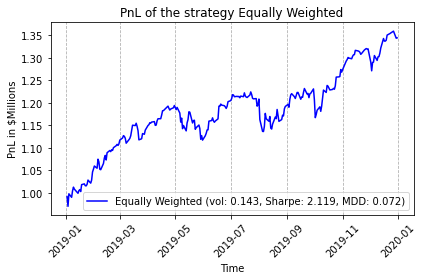

Sharpe Ratio: 2.1193296068317125
Max DD: 0.07191270295659913


In [82]:
EW_portfolio = Strategy('Equally Weighted',returns['EW Portfolio Return'])
EW_portfolio.illustrate()
print(f'Sharpe Ratio: {EW_portfolio.sharpe_ratio()}')
print(f"Max DD: {EW_portfolio.max_dd()}" )

# Minimum Variance Portfolio 

In this step,  we will first calculate the co-variance matrix of daily returns the top 10 market cap stocks of SBF120.

First we need to extract the data for prices of the stocks between 2017-18, check for any null values and proceed to calculate the covariance matrix of returns.

In [86]:

agg_price_data_top10_201718 = agg_price_data_top10[(agg_price_data.index >= '01/01/2017') & (agg_price_data.index <= '31/12/2018')].copy()
agg_price_data_top10_201718

,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity
Date,,,,,,,,,,
2017-01-02,181.80,48.800,173.45,77.84,62.82,201.39,390.830,60.350,107.30,87.1074
2017-01-03,179.70,48.930,170.15,78.30,63.50,199.06,389.144,61.920,106.30,87.3140
2017-01-04,178.10,48.905,169.85,78.30,63.40,196.41,386.021,62.800,105.40,87.2314
2017-01-05,176.95,48.930,170.30,78.27,64.60,194.83,384.732,62.220,105.40,87.2727
2017-01-06,179.25,48.770,170.25,76.69,65.14,197.95,387.409,62.490,105.80,87.6446
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,253.45,46.045,200.70,75.68,83.10,396.10,475.400,39.500,110.35,97.8182
2018-12-24,245.15,45.230,197.65,74.24,81.63,387.00,463.500,38.790,109.65,97.0909
2018-12-27,247.15,45.350,195.60,73.76,82.10,385.50,469.300,38.545,108.80,95.3182


In [87]:
for ticker in tqdm(agg_price_data_top10_201718.columns):
    if agg_price_data_top10_201718[ticker].isnull().values.any():
        print(ticker)
        nulls = agg_price_data_top10_201718[ticker].isnull()
        print(nulls[nulls == True].index)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 3187.89it/s]


In [88]:
returns_201718 = agg_price_data_top10_201718.pct_change().dropna().copy()
top10_cov_matrix = returns_201718.cov()


top10_cov_matrix 

,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity
MC FP Equity,0.000187,0.000061,0.000082,0.000043,0.000102,0.000177,0.000087,0.000065,0.000064,0.000079
TTE FP Equity,0.000061,0.000105,0.000036,0.000036,0.000059,0.000051,0.000027,0.000060,0.000029,0.000051
OR FP Equity,0.000082,0.000036,0.000108,0.000045,0.000060,0.000084,0.000050,0.000031,0.000049,0.000053
SAN FP Equity,0.000043,0.000036,0.000045,0.000106,0.000044,0.000032,0.000021,0.000039,0.000034,0.000045
AIR FP Equity,0.000102,0.000059,0.000060,0.000044,0.000227,0.000110,0.000053,0.000076,0.000056,0.000084
KER FP Equity,0.000177,0.000051,0.000084,0.000032,0.000110,0.000304,0.000101,0.000052,0.000059,0.000084
RMS FP Equity,0.000087,0.000027,0.000050,0.000021,0.000053,0.000101,0.000107,0.000025,0.000035,0.000039
BNP FP Equity,0.000065,0.000060,0.000031,0.000039,0.000076,0.000052,0.000025,0.000169,0.000033,0.000060
EL FP Equity,0.000064,0.000029,0.000049,0.000034,0.000056,0.000059,0.000035,0.000033,0.000143,0.000044
AI FP Equity,0.000079,0.000051,0.000053,0.000045,0.000084,0.000084,0.000039,0.000060,0.000044,0.000103


Now that we have the covariance matrix of returns for the 10 stocks, in this step we will find the weights of the minimum variance portfolio. 
For this, we will minimize the portfolio variance with the constraints that the weights of the assets sum up to 1 and are positive using the optimization library scipy. 

$$  \min w^t.\Sigma.w $$


$$st: \sum_{w_i} w_i = 1$$
$$ w_i >0 $$

Here, the minization problem doesn't take into account the returns of the portfolio and only the covariance matrix of returns, so it is deemed unncessary to annualize the covariance matrix by multiplying it by 252 (number of trading days). This is because the weights that are calculated from the minimization problem are normalized so that they sum to 1 so multiplying by any scalar gets cancelled out in the process, unless the scalar is a 0. 

After solving the minimization problem, the MV portfolio returns are added into the returns dataframe similar to the EW portfolio and a class Strategy object with the MV portfolio returns is created. The P&L graph along with sharpe ratio and the max drawdown for the Minimum Variance portfolio strategy is shown.

In [90]:

def portfolio_variance(weights):
    var = weights.T@top10_cov_matrix@weights
    
    return var


initial_weights = EW_daily_weights
constrain = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds =[(0, 1) for w in initial_weights] 
min_var_results = minimize(portfolio_variance, initial_weights, method = 'SLSQP', bounds = bounds, constraints = constrain, tol= 1e-12)
MV_port_weights = np.round(min_var_results.x,5)
print(MV_port_weights)
MV_portfolio_weighted_returns = returns.iloc[:,:10].dot(MV_port_weights)
returns['MV Portfolio Return'] = MV_portfolio_weighted_returns
returns.head()

#the library cvxpy was also used to test the results and we obtained similar results

# min_var_weights = cp.Problem(cp.Minimize(cp.quad_form(weights,top10_cov_matrix)), [cp.sum(weights) == 1, weights >= 0]) 
# min_var_weights.solve()
# mv_weights = np.round(weights.value, decimals =3)
# returns['MV portfolio returns']= returns.iloc[:,:10]@(mv_weights)
# print(mv_weights)
# returns


[0.      0.19731 0.07664 0.22215 0.      0.      0.251   0.07383 0.12863
 0.05045]


,MC FP Equity,TTE FP Equity,OR FP Equity,SAN FP Equity,AIR FP Equity,KER FP Equity,RMS FP Equity,BNP FP Equity,EL FP Equity,AI FP Equity,EW Portfolio Return,MV Portfolio Return
Date,,,,,,,,,,,,
2019-01-02,-0.018978,0.010286,-0.007952,-0.003436,0.002501,-0.021380,-0.014851,-0.009880,0.002263,-0.021669,-0.008310,-0.004603
2019-01-03,-0.038097,-0.008574,-0.012024,-0.009814,-0.035167,-0.054866,-0.028476,-0.005885,-0.009485,-0.018379,-0.022077,-0.014523
2019-01-04,0.030782,0.024970,0.014199,0.009108,0.048147,0.043867,0.029741,0.048514,0.010488,0.027845,0.028766,0.021839
2019-01-07,-0.001792,-0.002320,-0.012750,-0.019910,-0.018327,-0.002516,-0.011720,-0.001473,-0.001805,-0.005605,-0.007822,-0.009423
2019-01-08,0.031312,-0.002114,0.006077,0.007855,0.036979,0.035570,0.016307,0.005039,0.005425,0.001409,0.014386,0.007028


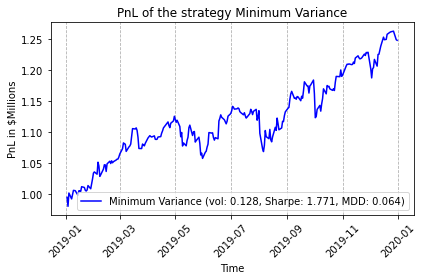

Sharpe Ratio: 1.7707945448486033
Max DD: 0.06361169015170609


In [91]:
MV_portfolio = Strategy('Minimum Variance',returns['MV Portfolio Return'])
MV_portfolio.illustrate()
print(f'Sharpe Ratio: {MV_portfolio.sharpe_ratio()}')
print(f"Max DD: {MV_portfolio.max_dd()}" )



# ERC PORTFOLIO

To calculate the ERC portfolio weights the following steps are implemented. 

Step 1: Calculucate the indivdual risk contributions of the assets, should sum up to 1 

Step 2: Define an objective function that minimizes the squared difference between the targeted risk contribution of assets to the risk contribution for a given asset weights and cov matrix


Step 3: Use this function within another function that gives the weights required to minimize the objective function defined above

Step 4: Obtain the weights of assets required in the portfolio such that the risk contributed by each asset is equal.


reference: 
- http://www.thierry-roncalli.com/download/erc-slides.pdf
- https://thequantmba.wordpress.com/2016/12/14/risk-parityrisk-budgeting-portfolio-in-python/


MC FP Equity     0.139787
TTE FP Equity    0.076208
OR FP Equity     0.088107
SAN FP Equity    0.065735
AIR FP Equity    0.128432
KER FP Equity    0.155766
RMS FP Equity    0.080584
BNP FP Equity    0.090150
EL FP Equity     0.080623
AI FP Equity     0.094608
dtype: float64


<AxesSubplot:title={'center':'Risk Contribution of Equally Weighted portfolio'}>

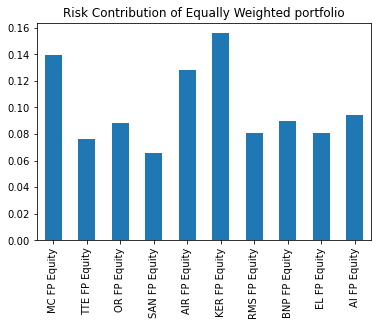

In [92]:
def risk_cont(w,cov_matrix):
    marginal_contribution = cov_matrix@w
    asset_risk_cont = np.multiply(marginal_contribution,w.T)/(portfolio_variance(w))
    #in the step above, we divide by (portfolio_variance(w)) and not the sqrt.(portfolio_variance(w)) because we want 
    # to calculate the risk contributions as weights such that weights add to 1 and not the exact values of risk 
    #that is contributed
    return  asset_risk_cont
print(risk_cont(EW_daily_weights,top10_cov_matrix))
risk_cont(EW_daily_weights,top10_cov_matrix).plot.bar(title = "Risk Contribution of Equally Weighted portfolio")

#Here we can visualize the risk contribution of each assets in the Equally weighted portfolio 

Equal Risk Contribution Weights:[0.07029751 0.11883042 0.10579816 0.1309197  0.07619266 0.06554881
 0.11829906 0.10209629 0.11255766 0.09945973]


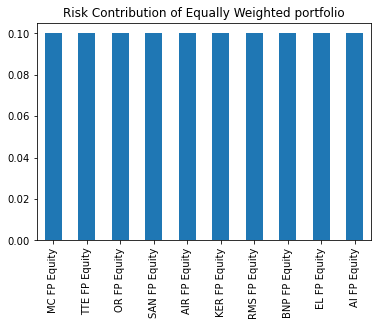

In [93]:
def weights_for_target_risk_contribution(target_risk, cov_matrix):
    initial_weight = np.random.random(10)
    bound = [(0,1) for r in target_risk]
    def mean_sdifference_risk(weights, target_risk, cov_matrix):
        return ((risk_cont(weights,cov_matrix)-target_risk)**2).sum()
    risk_cont_weights = minimize(mean_sdifference_risk, initial_weight, args =(target_risk, cov_matrix), method = "SLSQP",\
                                constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}),bounds = bound, tol=1e-12)
    return risk_cont_weights.x
ERC_risk_contributions = np.repeat(.1,10)
ERC_weights = weights_for_target_risk_contribution(ERC_risk_contributions, top10_cov_matrix)
print(f'Equal Risk Contribution Weights:{ERC_weights}')

ERC_portfolio_weighted_returns = returns.iloc[:,:10].dot(ERC_weights)
returns['ERC Portfolio Return'] = ERC_portfolio_weighted_returns


risk_cont(ERC_weights,top10_cov_matrix).plot.bar(title = "Risk Contribution of Equally Weighted portfolio")
plt.show()

#Here, we can visualize that the risk contribution of each asset is equal
                        

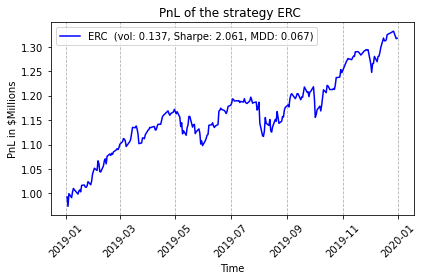

Sharpe Ratio: 2.0610404438045236
Max DD: 0.06718391947234059


In [94]:
ERC_portfolio = Strategy('ERC ',returns['ERC Portfolio Return'])
ERC_portfolio.illustrate()

print(f'Sharpe Ratio: {ERC_portfolio.sharpe_ratio()}')
print(f"Max DD: {ERC_portfolio.max_dd()}" )


# Final Result


Merged Plots of P&L for each strategy with respective volatility, sharpe ratio and Max Drawdown 

In [95]:
strategy_comparison = pd.DataFrame({"EW_portfolio":[EW_portfolio.sharpe_ratio(), EW_portfolio.max_dd()],
                                    'MV_portfolio':[MV_portfolio.sharpe_ratio(), MV_portfolio.max_dd()],
                                    'ERC_portfolio':[ERC_portfolio.sharpe_ratio(), ERC_portfolio.max_dd()],}, 
                                   index = ["Sharpe Ratio", "Max DD"]
                                  )
print(strategy_comparison)

              EW_portfolio  MV_portfolio  ERC_portfolio
Sharpe Ratio      2.119330      1.770795       2.061040
Max DD            0.071913      0.063612       0.067184


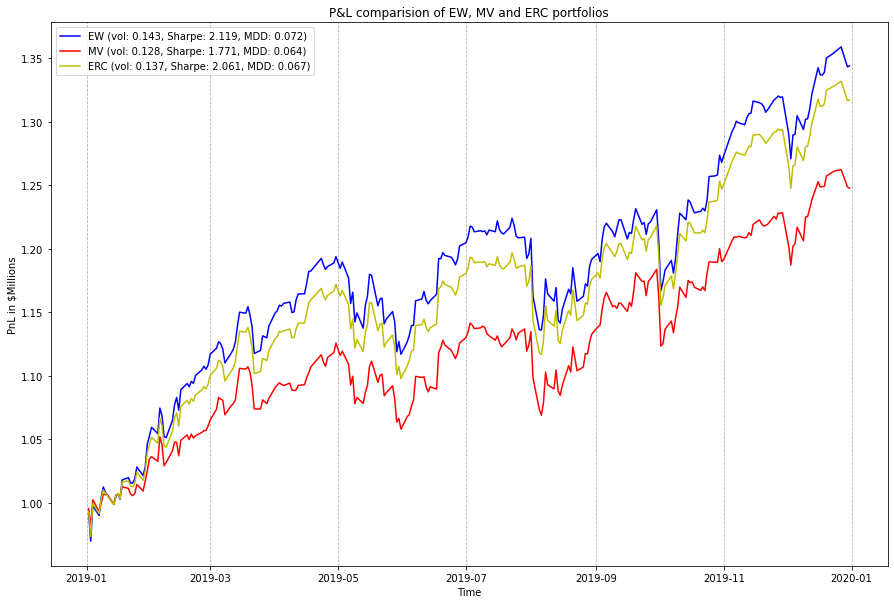

In [97]:


plt.plot(returns.index, EW_portfolio.pandl()[1:],'b', label='EW' + ' (vol: %.3f, Sharpe: %.3f, MDD: %.3f)'%
                                                      (EW_portfolio.volatility(), EW_portfolio.sharpe_ratio(), 
                                                       EW_portfolio.max_dd()))
plt.plot(returns.index, MV_portfolio.pandl()[1:], 'r', label='MV' + ' (vol: %.3f, Sharpe: %.3f, MDD: %.3f)'%
                                                      (MV_portfolio.volatility(), MV_portfolio.sharpe_ratio(), 
                                                       MV_portfolio.max_dd()))
plt.plot(returns.index, ERC_portfolio.pandl()[1:], 'y', label='ERC' + ' (vol: %.3f, Sharpe: %.3f, MDD: %.3f)'%
                                                      (ERC_portfolio.volatility(), ERC_portfolio.sharpe_ratio(), 
                                                       ERC_portfolio.max_dd()))

plt.xlabel('Time')
plt.ylabel('PnL in $Millions')
plt.title('P&L comparision of EW, MV and ERC portfolios')
plt.grid(axis='x', linestyle='--')
plt.legend(loc = 'best')
plt.rcParams["figure.figsize"] = (15,10) #for some reason I need to run this cell to twice to get the desired dimensions 
plt.show()


In conclusion, we can see that the ERC portfolio has volatility in between the EW and MV portfolio which matches with the theory provided by Thierry Roncalli.

$$\sigma_{mv }≤ \sigma_{erc} ≤ \sigma_{ew}$$

Purely interms of Profit and Loss , it seems that the EW has the best results. It also has the best sharpe ratio among all the porfolio, however the MDD is the higest for this porfolio. A risk-seeking investor would probably choose this porfolio over the rest of the portfolio. 

For a risk-neutral investor, the ERC portfolio seems like a good match given that both the MDD and sharpe ratio are in the middle for this portfolio. 

Finally, a risk averse investor would choose the MV portfolio given the least volatility and MDD for this portfolio. However, a risk averse investor would have to miss out on some profits for choosing this portfolio.